# Assignment #1
Riley Jackson<br>
Dr. Antonio Bolufe-Rohler<br>
February 25th, 2020<br>

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

# First, we obtain the raw data
data = np.genfromtxt('forestfires.csv', delimiter=',')
x = data[1:, 4:12]  # (num_examples, features)
y = data[1:, 12]  # (num_examples, )

# ML works best with normalized values
def normalize(array):
    return (array - np.mean(array, axis=0)) / np.std(array, axis=0)


x_normalized = normalize(x)
y_normalized = normalize(y)

# We should also split our dataset into a train/test split using sklearn functionality
# Setting a proper split ratio is difficult. The more data one has, the smaller the test
# fraction must be to be representative of the population. However, a model which trains
# well on less data is more robust than a model requiring significantly more data, so
# we'll keep the test fraction quite large for now
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y_normalized, test_size=0.30)

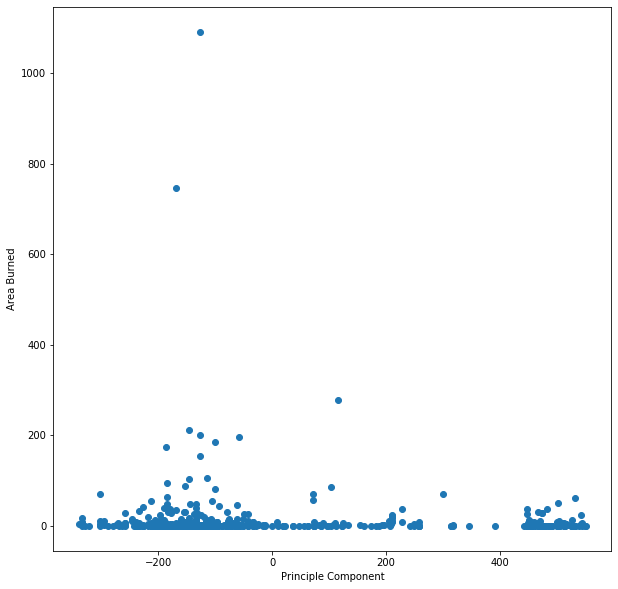

Total Variance ratio for PCA projection into R^1 space: 0.9626379470674833


In [20]:
# As this is a highly dimensional dataset, it's difficult to visualize the data directly. We can select
# specific dimensions to view, but we don't know which are important to the prediction task. Ideally, we
# want only to 2 degrees of freedom for visualization. We can attempt to project our data into a visualizable space
# using Principle Component Analysis (PCA)

from mpl_toolkits.mplot3d import Axes3D  # Oh how I love (hate) matplotlib...
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def two_d_plot(i, j):
    axis: plt.Axes = fig.add_subplot()
    axis.scatter(i, j)
    axis.set_xlabel('Principle Component')
    axis.set_ylabel('Area Burned')

def three_d_plot(i, j, k):
    axis: plt.Axes = fig.add_subplot(111, projection='3d')
    axis.scatter(i, j, k,
    )
    axis.set_xlabel('Principle Component 1')
    axis.set_ylabel('Principle Component 2')
    axis.set_zlabel('Area Burned')

n_components = 1  # Change this value to 2 to view a 3D plot
pca = PCA(n_components=n_components)
components = np.expand_dims(pca.fit_transform(x), axis=-1)  # (M, N, 1)

fig = plt.figure(figsize=[10, 10])
if n_components == 1:
    two_d_plot(components, y)
elif n_components == 2:
    three_d_plot(components[:, 0], components[:, 1], y)

plt.show()

print('Total Variance ratio for PCA projection into R^{} space: {}'.format(
    n_components, np.sum(pca.explained_variance_ratio_)
))

PCA is very useful for visualization, because now a single dimension represents all 8 of the original dataset
with a variance conservation of **~96%**. From the above plot we can see that *most* of our data has an an area burned
of around ${0\:m^2}$. This may cause trouble with our chosen regressors as they will likely bias towards
predictions of smaller areas. This plot also shows that the data seems to be non-linear, meaning that we'll likely have
to map our data into a new space using a kernel.

In [ ]:
# Once our data is normalized and ready to learn on, we need to select a model to test.
